# Datensatz n=103

In [2]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.linear_model
import torch.functional as F

# In diesem Package ist das Neuronale Netz, Training, Test und Informed Loss Funktionen ausgelagert.
import ConcreteNeuralNetwork_big as ConcreteNeuralNetwork

# import dataset
from sklearn.model_selection import train_test_split
#data = pd.read_excel("/home/hoschangn/Schreibtisch/WiSe 2021/AutoML/Concrete_Data.xls")
data = pd.read_csv("slump_test.csv")
w_c_ratio = data.iloc[:, 4].values/data.iloc[:, 1].values
data['Water/Cement Ratio'] = w_c_ratio
cols = data.columns.tolist()
cols[-1], cols[-2] = cols[-2], cols[-1]
cols[-2], cols[4] = cols[4], cols[-2]
data = data[cols]
X = torch.FloatTensor(data.iloc[:, 1:11].values)
y = torch.FloatTensor(data.iloc[:, 11].values)

means = X.mean(dim=0, keepdim=True)
stds = X.std(dim=0, keepdim=True)
X = (X - means) / stds

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.76, random_state=1)
print('Average: {}, Standard Deviation: {}'.format(means, stds))

data[cols].head()

Average: tensor([[229.8942,  77.9738, 149.0146,   0.9620,   8.5398, 883.9785, 739.6048,
          18.0485,  49.6107, 197.1680]]), Standard Deviation: tensor([[78.8772, 60.4614, 85.4181,  0.3318,  2.8075, 88.3914, 63.3421,  8.7508,
         17.5686, 20.2082]])


,No,Cement,Slag,Fly ash,Water/Cement Ratio,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Water,Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,0.769231,9.0,904.0,680.0,23.0,62.0,210.0,34.99
1,2,163.0,149.0,191.0,1.104294,12.0,843.0,746.0,0.0,20.0,180.0,41.14
2,3,162.0,148.0,191.0,1.104938,16.0,840.0,743.0,1.0,20.0,179.0,41.81
3,4,162.0,148.0,190.0,1.104938,19.0,838.0,741.0,3.0,21.5,179.0,42.08
4,5,154.0,112.0,144.0,1.428571,10.0,923.0,658.0,20.0,64.0,220.0,26.82


## Neural Network

In [3]:
model = ConcreteNeuralNetwork.ConcreteNN()
loss_over_time, test_loss_over_time = ConcreteNeuralNetwork.train(model, X_train, y_train, X_test, y_test)

plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (78x10 and 9x9)

Train R2: 0.8957324250730899, Train RMSE: 5.3570826053619385
Test R2: 0.6613243424368352, Test RMSE: 7.737171936035156


<ErrorbarContainer object of 3 artists>

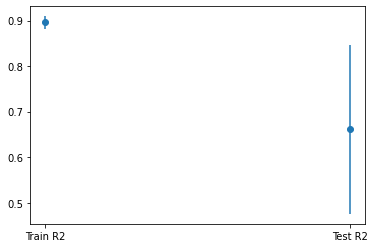

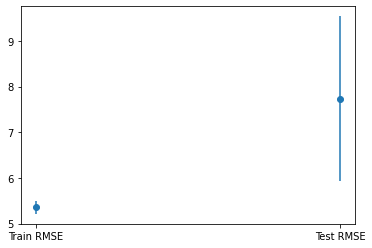

In [3]:
# 10-Fold Cross Validation
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
import sklearn.model_selection
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = ConcreteNeuralNetwork.ConcreteNN()
    ConcreteNeuralNetwork.train(model, X_train, y_train, X_test, y_test)
    
    test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
    train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

r2_names = ['Train R2', 'Test R2']
rmse_names = ['Train RMSE', 'Test RMSE']
plt.figure()
plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
plt.figure()
plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')


# Informed Machine Learning: Custom Loss Function

## Plot linear relationship

In [4]:
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Water/Cement Ratio,Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),Superplasticizer (component 5)(kg in a m^3 mixture),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,0.300000,1040.0,676.0,28,2.5,79.986111
1,540.0,0.0,0.0,162.0,0.300000,1055.0,676.0,28,2.5,61.887366
2,332.5,142.5,0.0,228.0,0.685714,932.0,594.0,270,0.0,40.269535
3,332.5,142.5,0.0,228.0,0.685714,932.0,594.0,365,0.0,41.052780
4,198.6,132.4,0.0,192.0,0.966767,978.4,825.5,360,0.0,44.296075


In [5]:
LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
lr_input = torch.log10(torch.hstack((torch.ones((X.shape[0], 1)), X[:, [4, 0, 5, 6]])))
#lr_input = torch.log10(torch.hstack((torch.ones((X.shape[0], 1)), X[:, [3, 0, 5, 6]])))
ln_y = torch.log10(y)
LR.fit(lr_input, ln_y)
LR.coef_
y_pred = 10 ** LR.predict(lr_input)
print(sklearn.metrics.r2_score(y, y_pred))
plt.plot(y)
plt.plot(y_pred)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [5]:
def informed_loss(inputs, outputs, targets, lamb):
    LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
    lr_input = torch.log10(torch.hstack((torch.ones((inputs.shape[0], 1)), inputs[:, [3, 0, 5, 6]])))
    ln_y = torch.log10(targets)
    LR.fit(lr_input, ln_y)
    lr_predictions = torch.FloatTensor(10**LR.predict(lr_input))
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(outputs - lr_predictions)
    
    return mse(outputs, targets) + lamb*relu(info)

In [6]:
def informed_loss(inputs, outputs, targets, lamb):
    LR = sklearn.linear_model.LinearRegression(fit_intercept=False)
    lr_input = torch.log10(torch.hstack((torch.ones((inputs.shape[0], 1)), inputs[:, [3, 0, 5, 6]])))
    ln_y = torch.log10(targets)
    LR.fit(lr_input, ln_y)
    lr_predictions = torch.FloatTensor(10**LR.predict(lr_input))
    mse = nn.MSELoss()
    relu = nn.ReLU()
    info = torch.sum(outputs - lr_predictions)
    
    return mse(outputs, targets) + lamb*mse(outputs, lr_predictions)

Train R2: 0.9844862769604006, Train RMSE: 0.9599675536155701
Test R2: 0.8139402621513492, Test RMSE: 2.3320040583610533
Train R2: 0.9750266559266392, Train RMSE: 1.2261218309402466
Test R2: 0.8357064815684291, Test RMSE: 2.3770981192588807
Train R2: 0.7792588812215119, Train RMSE: 3.6552043199539184
Test R2: 0.5676018948932142, Test RMSE: 3.9748034715652465


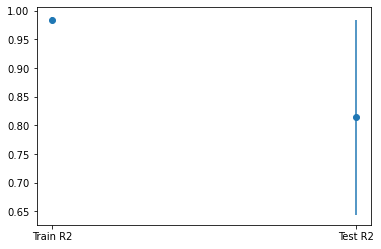

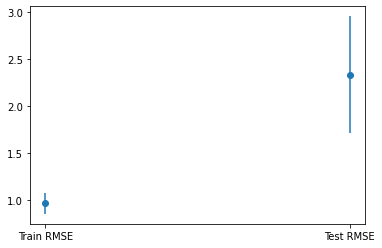

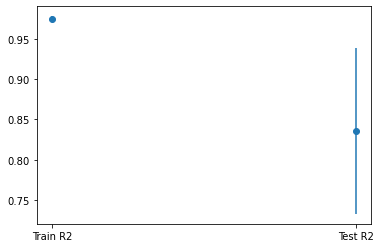

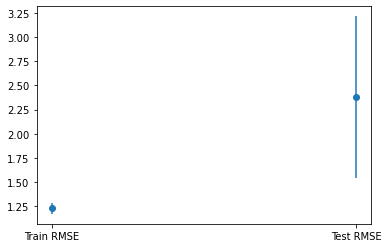

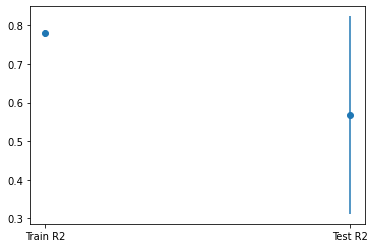

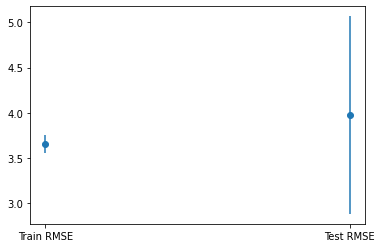

In [8]:
# 10-Fold Cross Validation
K = 10
lambdas = [0.01, 0.1, 1]
import sklearn.model_selection
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for lamb in lambdas:
    test_r2_list = []
    test_rmse_list = []
    train_r2_list = []
    train_rmse_list = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        time_data_train = torch.FloatTensor(data.iloc[train_index, 1:11].values)
        X_train = torch.FloatTensor(X_train)
        X_test = torch.FloatTensor(X_test)
        y_train = torch.FloatTensor(y_train)
        y_test = torch.FloatTensor(y_test)

        model = ConcreteNeuralNetwork.ConcreteNN()
        ConcreteNeuralNetwork.train_with_closs(model, informed_loss, lamb, inform_data, X_train, y_train, X_test, y_test)
        
        test_r2, test_rmse = ConcreteNeuralNetwork.eval_model(model, X_test, y_test)
        train_r2, train_rmse = ConcreteNeuralNetwork.eval_model(model, X_train, y_train)

        test_r2_list.append(test_r2)
        test_rmse_list.append(test_rmse)
        train_r2_list.append(train_r2)
        train_rmse_list.append(train_rmse)

    print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
    print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

    train_r2_mean = torch.mean(torch.FloatTensor(train_r2_list)).item()
    train_r2_std = torch.std(torch.FloatTensor(train_r2_list)).item()
    train_rmse_mean = torch.mean(torch.FloatTensor(train_rmse_list)).item()
    train_rmse_std = torch.std(torch.FloatTensor(train_rmse_list)).item()
    test_r2_mean = torch.mean(torch.FloatTensor(test_r2_list)).item()
    test_r2_std = torch.std(torch.FloatTensor(test_r2_list)).item()
    test_rmse_mean = torch.mean(torch.FloatTensor(test_rmse_list)).item()
    test_rmse_std = torch.std(torch.FloatTensor(test_rmse_list)).item()

    r2_names = ['Train R2', 'Test R2']
    rmse_names = ['Train RMSE', 'Test RMSE']
    plt.figure()
    plt.errorbar(r2_names, [train_r2_mean, test_r2_mean], [train_r2_std, test_r2_std], linestyle='None', marker='o')
    plt.figure()
    plt.errorbar(rmse_names, [train_rmse_mean, test_rmse_mean], [train_rmse_std, test_rmse_std], linestyle='None', marker='o')